In [ ]:
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from collections import Counter
from scipy.optimize import curve_fit

Surviving individuals per species: Counter({1: 100, 6: 99, 8: 99, 2: 98, 3: 98, 4: 98, 5: 98, 7: 98, 9: 98, 0: 97})


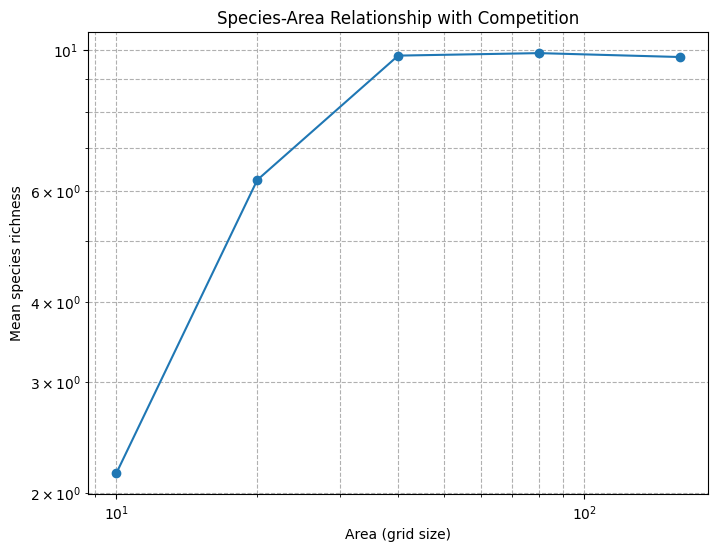

In [ ]:
Lx, Ly = 200, 200               
n_species = 10                   
n_individuals_per_species = 100  
radius = 5.0                     # Competition radius
threshold_intake = 0.1           # Minimum intake for survival

# Generate resource field
Res = np.random.gamma(shape=2.0, scale=1.0, size=(Lx, Ly))

class Individual:
    def __init__(self, x, y, species_id):
        self.x = x
        self.y = y
        self.species_id = species_id
        self.comp = 5.0     # species competition coefficient

# Positions for each species
grid_points = []
for s in range(n_species):
    inds = [Individual(np.random.uniform(0,Lx),
                       np.random.uniform(0,Ly),
                       s) for _ in range(n_individuals_per_species)]
    grid_points.append(inds)

all_individuals = [ind for species in grid_points for ind in species]

comp_values = np.random.rand(n_species)  # species-specific competition
for species_idx, species in enumerate(grid_points):
    comp = comp_values[species_idx]
    for ind in species:
        ind.comp = comp

def ind_resource_species(ind, all_inds, Res, radius):
    # Find neighbours (exclude self)
    neighbours = [j for j in all_inds if j != ind and np.hypot(ind.x - j.x, ind.y - j.y) < radius]
    
    total_comp = sum(j.comp for j in neighbours)
    
    # Available resource at individual's location
    x_idx = int(np.clip(ind.x, 0, Res.shape[0]-1))
    y_idx = int(np.clip(ind.y, 0, Res.shape[1]-1))
    available = Res[x_idx, y_idx]
    
    intake = available / (1 + total_comp)
    return intake

# Compute intake & survival
surviving_inds = []
for ind in all_individuals:
    intake = ind_resource_species(ind, all_individuals, Res, radius)
    if intake >= threshold_intake:
        surviving_inds.append(ind)

# Species distribution
species_counts = Counter(ind.species_id for ind in surviving_inds)
print("Surviving individuals per species:", species_counts)

# Species-Area Relationship (SAR)
def species_richness_grid(surviving_inds, grid_size, Lx, Ly):
    richness = []
    for i in range(0, Lx, grid_size):
        for j in range(0, Ly, grid_size):
            subgrid_inds = [ind for ind in surviving_inds
                            if i <= ind.x < i+grid_size and j <= ind.y < j+grid_size]
            richness.append(len(set(ind.species_id for ind in subgrid_inds)))
    return np.array(richness)

grid_sizes = [10, 20, 40, 80, 160]  # Different sampling areas
SAR = []

for gs in grid_sizes:
    richness = species_richness_grid(surviving_inds, gs, Lx, Ly)
    SAR.append(np.mean(richness))

plt.figure(figsize=(8,6))
plt.loglog(grid_sizes, SAR, marker='o')
plt.xlabel("Area (grid size)")
plt.ylabel("Mean species richness")
plt.title("Species-Area Relationship with Competition")
plt.grid(True, which="both", ls="--")
plt.show()


Fitted power law to mean SAR: S = 2.34 * A^0.31


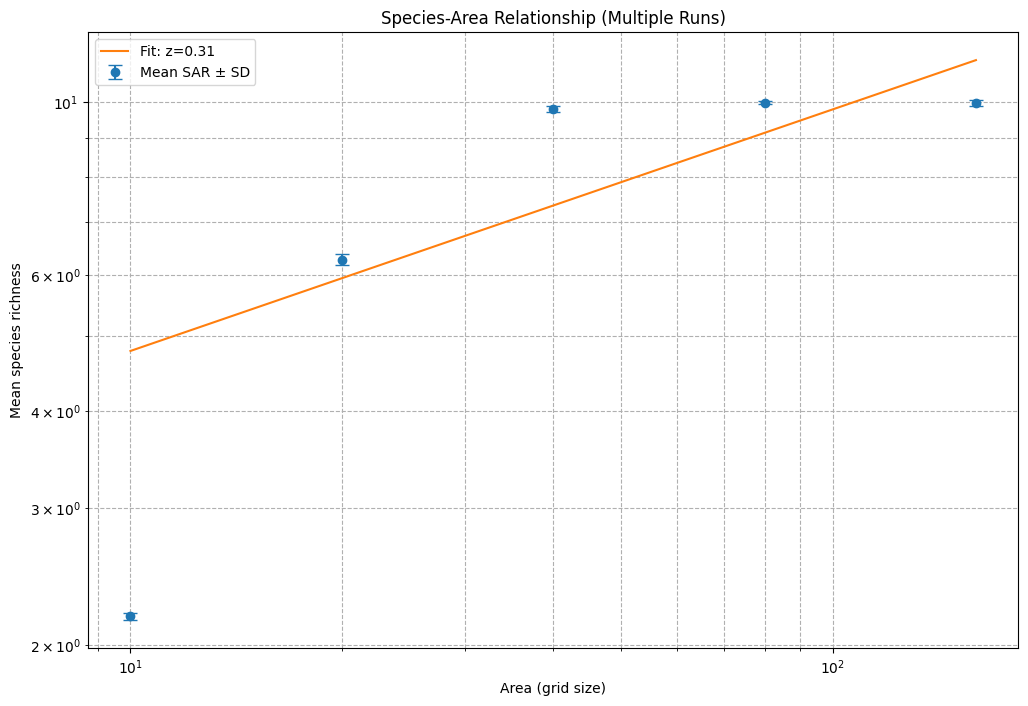

In [5]:
# Simulation
n_runs = 100
SAR_runs = []

for run in range(n_runs):
    Res = np.random.gamma(shape=2.0, scale=1.0, size=(Lx, Ly))

    grid_points = []
    for s in range(n_species):
        inds = [Individual(np.random.uniform(0,Lx),
                       np.random.uniform(0,Ly),
                       s) for _ in range(n_individuals_per_species)]
        grid_points.append(inds)

    all_inds = [ind for species in grid_points for ind in species]

    for species_idx, species in enumerate(grid_points):
        comp = comp_values[species_idx]
        for ind in species:
            ind.comp = comp
    
    surviving_inds = []
    for ind in all_inds:
        intake = ind_resource_species(ind, all_inds, Res, radius)
        if intake >= threshold_intake:
            surviving_inds.append(ind)
    
    SAR_run = []
    for gs in grid_sizes:
        richness = species_richness_grid(surviving_inds, gs, Lx, Ly)
        SAR_run.append(np.mean(richness))
    SAR_runs.append(SAR_run)


SAR_mean = np.mean(SAR_runs, axis=0)
SAR_std = np.std(SAR_runs, axis=0)

def power_law(A, c, z):
    return c * A**z

params, _ = curve_fit(power_law, np.array(grid_sizes), SAR_mean, p0=[1, 0.2])
c_fit, z_fit = params
print(f"Fitted power law to mean SAR: S = {c_fit:.2f} * A^{z_fit:.2f}")


plt.figure(figsize=(12,8))
plt.errorbar(grid_sizes, SAR_mean, yerr=SAR_std, fmt='o', capsize=5, label='Mean SAR ± SD')
plt.loglog(grid_sizes, power_law(np.array(grid_sizes), *params), '-', label=f'Fit: z={z_fit:.2f}')
plt.xlabel("Area (grid size)")
plt.ylabel("Mean species richness")
plt.title("Species-Area Relationship (Multiple Runs)")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
